In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import optimize
import numpy as np
import yfinance as yf

In [2]:
sp500_url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'
sp500_df = pd.read_csv(sp500_url)
ticker_list = list(sp500_df.Symbol)
data = yf.download(' '.join(ticker_list), period='1y')
print(data.shape)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
(253, 3030)


In [3]:
# get tickers with price history
price=data['Adj Close']
price=price.dropna(axis=1,how='all') # column wise drop bad ticker.
cols = []
for x in price.columns:
    nancount = np.sum(np.isnan(price[x]))
    if nancount <= 1:
        cols.append(x)
price=price[cols].dropna() # row wise drop bad days.
print(price.shape)

(252, 502)


In [4]:
# compute log return
ret = pd.DataFrame(
    np.diff(np.log(price),axis=0),
    index=price.index[1:],
    columns=price.columns
)
print(ret.shape)

(251, 502)


(251, 502)


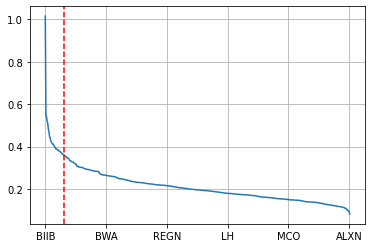

In [5]:
# compute historical volatility 
# (don't have implied volatility, thus will use historical volatility as proxy)
vola = ret.rolling(30,center=False).std()*np.sqrt(252)
print(vola.shape)
vola.iloc[-1,:].sort_values(ascending=False).plot().grid(True)
plt.axvline(30,color='red',linestyle='--')

In [6]:
# obtain list of candidates `cand_list` with high volatility at last day.
sample_size = 30
tmp = vola.iloc[-1,:].sort_values(ascending=False)[:sample_size]
cand_list = list(tmp.index)

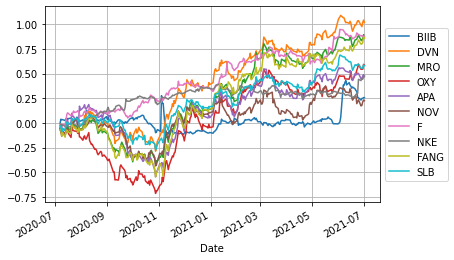

In [18]:
ret[cand_list].iloc[:,:].cumsum(axis=0).iloc[:,:10].plot().grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(30, 30)


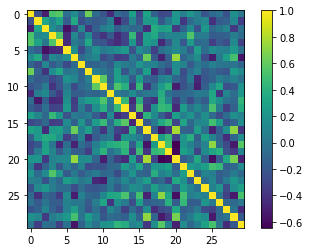

In [19]:
# observe correlation with return from past 30 days.
tmp_ret = ret[cand_list][-30:]
print(tmp_ret.shape)
corr = np.corrcoef(tmp_ret)
plt.imshow(corr)
plt.colorbar()

In [20]:
lookback = -60
myret = np.array(ret[cand_list][lookback:]).T
print(myret.shape)
def variance(x,*args):    
    p = np.squeeze(np.asarray(args))
    Acov = np.cov(p)
    v = np.dot(x,np.dot(Acov,x))
    return v

ret_mean = myret.mean(axis=1)
ret_std = myret.std(axis=1)
ret_norm = ret_mean/ret_std

x,_=myret.shape
print(x)
eps = 1e-8
bnds = tuple([(-0.2,0.2)]*x) #long and short
weights = tuple([0.5]*x)
cons = (
    {'type': 'eq', 'fun': lambda x:  np.dot(x,ret_norm)-0}, # so that sharpe is 0
    {'type': 'eq', 'fun': lambda x:  np.sum(np.abs(x))-1.0}, # let weights adds up to 1
)

res=optimize.minimize(variance, weights, args=myret, method='SLSQP',constraints=cons,bounds=bnds)
myweights = np.expand_dims(np.array([round(y,2) for y in res.x]),axis=-1)
print('weights: {}'.format(' '.join(['{:1.2f}'.format(x) for x in myweights.squeeze()])))
print(np.sum(np.abs(myweights)))

(30, 60)
30
weights: 0.06 -0.03 -0.01 -0.07 0.00 0.01 0.03 0.03 -0.05 0.01 0.06 0.05 0.07 -0.00 0.03 0.03 0.01 0.04 0.02 0.10 0.02 -0.04 0.02 0.03 0.05 0.07 0.00 0.03 0.02 0.02
1.0100000000000002


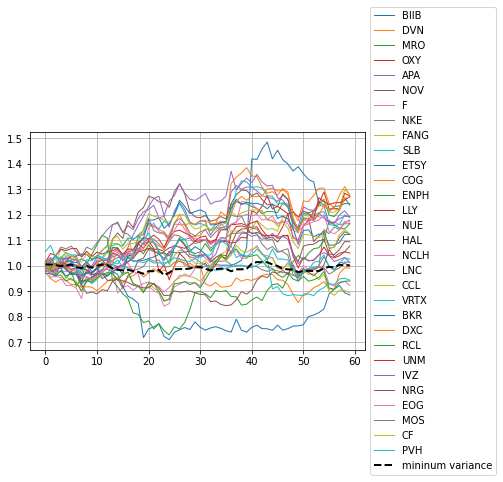

In [21]:
price = np.cumprod(1+myret,axis=1).T
df = pd.DataFrame.from_records(price,columns=cand_list)
df.plot(legend=False,linewidth=1,linestyle='-')

port = np.sum(myweights*myret,axis=0)
port = np.cumprod(1+port)
plt.plot(port,color='black',label='mininum variance',linewidth=2,linestyle='--')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [25]:
mypick = pd.DataFrame(myweights,columns=['weights'],index=cand_list)
mypick

,weights
BIIB,0.06
DVN,-0.03
MRO,-0.01
OXY,-0.07
APA,0.00
NOV,0.01
F,0.03
NKE,0.03
FANG,-0.05
SLB,0.01


In [31]:
#price
#ret[cand_list]
#vola[cand_list]

<AxesSubplot:xlabel='Date'>

<Figure size 432x288 with 0 Axes>

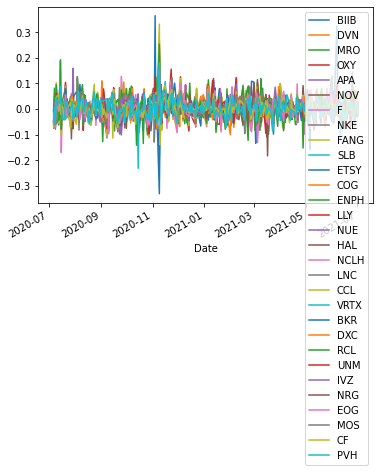

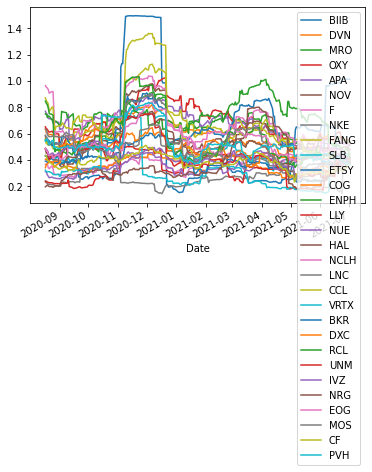

In [34]:
plt.figure(0)
ret[cand_list].plot()
plt.figure(1)
vola[cand_list].plot()

In [23]:

# pick 
def main(ret,n=20):
    # pick `n` most volatile stock (based on volatility z-score from past 4 weeks)
    (ret.std(axis=1).shape)
    
    # compute z-score for both volatility and price: pz, vz.
    
    # compute their first and second derivative.
    # zscore of price & volatilitty, and their 1st and 2nd derivatives: dpz, ddpz, dvz, ddvz.

#main(ret)